# Hypothetical Document Embeddings (HyDE)

Research Paper -> https://arxiv.org/abs/2212.10496

### How it Works?

Given a query, the Hypothetical Document Embeddings (HyDE) first zero-shot prompts an instruction-following language model to generate a “fake” hypothetical document that captures relevant textual patterns from the initial query - in practice, this is done five times. Then, it encodes each hypothetical document into an embedding vector and averages them. The resulting, single embedding can be used to identify a neighbourhood in the document embedding space from which similar actual documents are retrieved based on vector similarity. As with any other retriever, these retrieved documents can then be used downstream in a pipeline (for example, in a Generator for RAG).

### When Is It Helpful?

The HyDE method is highly useful when:

* The performance of the retrieval step in your pipeline is not good enough (for example, low Recall metric).
* Your retrieval step has a query as input and returns documents from a larger document base.
* Particularly worth a try if your data (documents or queries) come from a special domain that is very different from the typical datasets that Retrievers are trained on.

(Source -> [Haystack HyDE Article](https://docs.haystack.deepset.ai/docs/hypothetical-document-embeddings-hyde))

### Table of Contents

1. **Load Data**
    * Split Data into Chunks
2. **Create Vector Store & Load Text Chunks**
    * Define Vector Store & Collection
    * Add Text Chunks to Collection
    * Visualize Dataset
3. **Query Vector Store**
    * Visualize Original Query & Retrieved Docs
4. **HyDE**
    * Visualize Original Query & Retrieved Docs
5. **HyDE (Avg. Embeddings of Answers)**
    * Visualize Original Query & Retrieved Docs
6. **RAG Performance**

### Installation

* **pip install groq**
* **pip install langchain**
* **pip install chromadb**

In [1]:
import dotenv
import os

dotenv.load_dotenv(dotenv.find_dotenv())

groq_api_key = os.environ["GROQ_API_KEY"]

In [2]:
import chromadb

print(chromadb.__version__)

0.5.4


* Login to **https://console.groq.com** and create API Key.

<img src="GroqModels.jpg" width=800/>

In [3]:
from groq import Groq

client = Groq(
    api_key=groq_api_key,
)

## 1. Load Data

* **Form 10-K** is a comprehensive report filed annually by a publicly traded company about its financial performance and is required by the **U.S. Securities and Exchange Commission (SEC)**.



In [4]:
from pypdf import PdfReader

reader = PdfReader("Meta-10-k-2023.pdf")

pages = [page.extract_text().strip() for page in reader.pages]
pages = [page for page in pages if page]

len(pages)

147

In [5]:
print(pages[0])

UNITED ST ATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549
__________________________
FORM 10-K
__________________________
(Mark One)
☒    ANNUAL  REPOR T PURSUANT  TO SECTION 13 OR 15(d) OF  THE SECURITIES EXCHANGE ACT  OF 1934
For the fiscal year  ended December  31, 2023
or
☐    TRANSITION REPOR T PURSUANT  TO SECTION 13 OR 15(d) OF  THE SECURITIES EXCHANGE ACT  OF 1934
For the transition period fr om            to            
Commission File Number: 001-35551
__________________________
Meta Platforms, Inc.
(Exact name of r egistrant as specified in its charter)
__________________________
Delawar e 20-1665019
(State or other jurisdiction of incorporation or organization) (I.R.S. Employer Identification Number)
1 Meta Way, Menlo Park, California 94025
(Address of principal executive offices and Zip Code)
(650) 543-4800
(Registrant's telephone number, including area code)
__________________________
Securities r egister ed pursuant to Section 12(b) of the Act:
Title of ea

### 1.1 Split Data into Text Chunks

In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter, SentenceTransformersTokenTextSplitter

text_splitter  = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", ". ", " ", ""],
    chunk_size=1000,
    chunk_overlap=25        
)

character_split_texts = text_splitter.split_text('\n\n'.join(pages))

print(f"Total chunks: {len(character_split_texts)}")

Total chunks: 634


In [7]:
print((character_split_texts[10]))

these risks and uncertainties, readers are cautioned not to place undue reliance on such forward‑looking statements.
Unless expressly indicated or the context requires otherwise, the terms "Meta," "company," "we," "us," and "our" in this document refer to Meta
Platforms, Inc., a Delaware corporation, and, where appropriate, its subsidiaries. The term "Family" refers to our Facebook, Instagram, Messenger, and
WhatsApp products. For references to accessing Meta's products on the "web" or via a "website," such terms refer to accessing such products on personal
computers. For references to accessing Meta's products on "mobile," such term refers to accessing such products via a mobile application or via a mobile-
optimized version of our websites such as m.facebook.com, whether on a mobile phone or tablet.
3


## 2. Create Vector Store & Load Text Chunks

### 2.1 Define Vector Store & Collection

* https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#original-models

Check out our **[ChromaDB Tutorial](https://www.youtube.com/watch?v=-ElKVZRNcU8&t=673s)** if you are new to it.

In [8]:
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

chroma_client = chromadb.PersistentClient(path="./meta_10_k")
distilroberta = SentenceTransformerEmbeddingFunction(model_name="all-distilroberta-v1")

collection = chroma_client.create_collection(name="meta_annual_report_2023", 
                                             metadata={"title": "Meta 10-k Report (2023)", 
                                                       "description": "This store contains embeddings of Meta Annual Report filed to SEC for 2023."},
                                             embedding_function=distilroberta,
                                             get_or_create=True)

### 2.2 Add Text Chunks to Vector Store

* Do not rerun this step if you have already ran it earlier. It'll add same texts again in persisted collection.

In [9]:
collection.add(
    documents=character_split_texts,
    ids=[f"Split-{idx}" for idx in range(len(character_split_texts))]
)

In [9]:
collection.count()

634

### 2.3 Visualize Text Chunks

In [10]:
import umap
import numpy as np
from tqdm import tqdm

embeddings = collection.get(include=['embeddings'])['embeddings']
umap_projector = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)

def project_embeddings(embeddings, umap_projector):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)): 
        umap_embeddings[i] = umap_projector.transform([embedding])
    return umap_embeddings   

projected_dataset_embeddings = project_embeddings(embeddings, umap_projector)

2024-08-16 00:47:19.501483: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 00:47:19.536917: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-16 00:47:20.245448: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
100%|█████████████████████████████████████████████████████████████████████████████████| 634/634 [05:07<00:00,  2.06it/s]


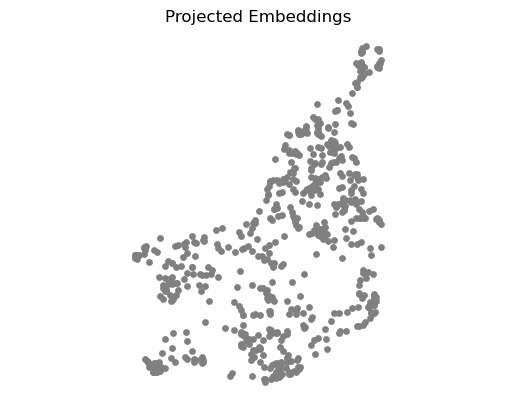

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="grey")
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.axis('off');

## 3. Query Vector Store

In [13]:
query = "What are risk factors for the company?"

results = collection.query(query_texts=[query], n_results=10, include=['documents', 'embeddings'])

results.keys()

dict_keys(['ids', 'distances', 'metadatas', 'embeddings', 'documents', 'uris', 'data', 'included'])

In [14]:
retrieved_documents1 = results['documents'][0]

for document in retrieved_documents1:
    print(document)
    print('==========================================')

Summary Risk Factors
Our business is subject to a number of risks, including risks that may prevent us from achieving our business objectives or may adversely affect our
business, financial condition, results of operations, cash flows, and prospects. These risks are discussed more fully below and include, but are not limited to,
risks related to:
Risks Related to Our Product Offerings
•our ability to add and retain users and maintain levels of user engagement with our products;
•the loss of, or reduction in spending by, our marketers;
•reduced availability of data signals used by our ad targeting and measurement tools;
•ineffective operation with mobile operating systems or changes in our relationships with mobile operating system partners;
•failure of our new products, or changes to our existing products, to attract or retain users or generate revenue;
Risks Related to Our Business Operations and Financial Results
•our ability to compete effectively;
criminal liability (including liab

### Visualize Query & Retrieved Docs

In [15]:
retrieved_docs_embeddings = results['embeddings'][0]
original_query_embeddings = distilroberta([query])

projected_original_query_embedding = project_embeddings(original_query_embeddings, umap_projector)
projected_retrieved_embeddings = project_embeddings(retrieved_docs_embeddings, umap_projector)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.06it/s]


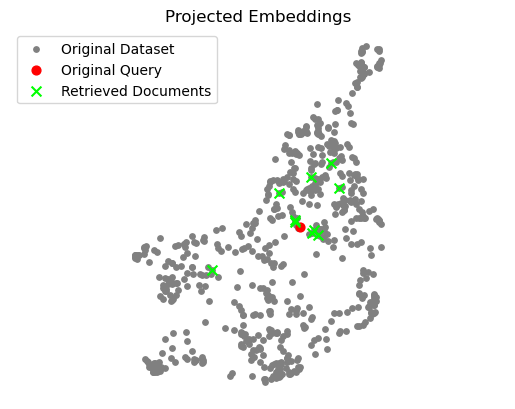

In [16]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="grey", label="Original Dataset")
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=40, c="red", label="Original Query")
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=50, marker="x", c="lime", label="Retrieved Documents")
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.legend(loc="best");
plt.axis('off');

## 4. HyDE (Hypothetical Document Embeddings)



In [17]:
def generate_answer(query, model="llama-3.1-70b-versatile"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example brief answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

generated_answer = generate_answer(query)

print(generated_answer)

**Risk Factors**

As with any business, we face a number of risks that could impact our financial condition, results of operations, and overall success. Some of the key risk factors include:

* **Macroeconomic Risks**: Economic downturns, recession, or changes in government policies could lead to reduced consumer spending, decreased demand for our products, and increased competition.
* **Industry Competition**: The industry in which we operate is highly competitive, and we face competition from established brands and new entrants. If we are unable to compete effectively, our market share and revenue could decline.
* **Regulatory Risks**: Changes in laws, regulations, or industry standards could require us to make significant investments in new technologies or processes, potentially disrupting our operations and increasing costs.
* **Supply Chain Disruptions**: Disruptions to our supply chain, such as natural disasters, transportation disruptions, or supplier insolvency, could impact ou

In [18]:
answer_embeddings = distilroberta([generated_answer])

In [19]:
results = collection.query(query_embeddings=answer_embeddings, ## query_texts=[generated_answer]
                           n_results=10,
                           include=['documents', 'embeddings'])

retrieved_documents2 = results['documents'][0]

for document in retrieved_documents2:
    print(document)
    print('==========================================')

Summary Risk Factors
Our business is subject to a number of risks, including risks that may prevent us from achieving our business objectives or may adversely affect our
business, financial condition, results of operations, cash flows, and prospects. These risks are discussed more fully below and include, but are not limited to,
risks related to:
Risks Related to Our Product Offerings
•our ability to add and retain users and maintain levels of user engagement with our products;
•the loss of, or reduction in spending by, our marketers;
•reduced availability of data signals used by our ad targeting and measurement tools;
•ineffective operation with mobile operating systems or changes in our relationships with mobile operating system partners;
•failure of our new products, or changes to our existing products, to attract or retain users or generate revenue;
Risks Related to Our Business Operations and Financial Results
•our ability to compete effectively;
existing products or services, del

### Visualize Query, Answer & Retrieved Docs

In [20]:
retrieved_docs_embeddings = results['embeddings'][0]
original_query_embeddings = distilroberta([query])

projected_original_query_embedding = project_embeddings(original_query_embeddings, umap_projector)
projected_generated_answer_embedding = project_embeddings(answer_embeddings, umap_projector)
projected_retrieved_embeddings = project_embeddings(retrieved_docs_embeddings, umap_projector)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.18it/s]


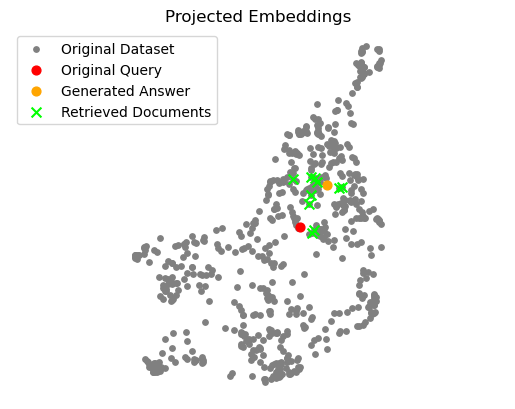

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="grey", label="Original Dataset")
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=40, c="red", label="Original Query")
plt.scatter(projected_generated_answer_embedding[:, 0], projected_generated_answer_embedding[:, 1], s=40, c="orange", label="Generated Answer")
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=50, marker="x", c="lime", label="Retrieved Documents")
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.legend(loc="best");
plt.axis('off');

## 5. HyDE (Averaging Embeddings of Multiple Answers)

In [22]:
generated_answers = [generate_answer(query) for i in range(5)]

for idx, answer in enumerate(generated_answers, start=1):
    print(f"========== Answer: {idx} ============\n\n")
    print(answer)

========== Answer: 1 ============


**Risk Factors**

The company is exposed to various risks that could have a material adverse effect on our business, financial condition, and results of operations. Some of the key risk factors include:

* **Market Risks**: We are exposed to fluctuations in global economic conditions, interest rates, and currency exchange rates, which could impact our revenue, profitability, and cash flows.
* **Competition Risks**: The industry in which we operate is highly competitive, and we face competition from established players and new entrants, which could impact our market share and pricing power.
* **Regulatory Risks**: Changes in laws, regulations, and government policies could impact our operations, increase our costs, and reduce our revenue.
* **Operational Risks**: We are exposed to risks related to our supply chain, manufacturing processes, and information technology systems, which could impact our ability to deliver products and services to our custom

In [23]:
import numpy as np

answers_embeddings = distilroberta(generated_answers)

answers_embeddings = np.array(answers_embeddings)

answers_embeddings.shape

(5, 768)

In [24]:
avg_answers_embeddings = answers_embeddings.mean(axis=0)

avg_answers_embeddings.shape

(768,)

In [25]:
results = collection.query(query_embeddings=avg_answers_embeddings.reshape(1,-1),
                           n_results=10,
                           include=['documents', 'embeddings'])

retrieved_documents3 = results['documents'][0]

for document in retrieved_documents3:
    print(document)
    print('==========================================')

Summary Risk Factors
Our business is subject to a number of risks, including risks that may prevent us from achieving our business objectives or may adversely affect our
business, financial condition, results of operations, cash flows, and prospects. These risks are discussed more fully below and include, but are not limited to,
risks related to:
Risks Related to Our Product Offerings
•our ability to add and retain users and maintain levels of user engagement with our products;
•the loss of, or reduction in spending by, our marketers;
•reduced availability of data signals used by our ad targeting and measurement tools;
•ineffective operation with mobile operating systems or changes in our relationships with mobile operating system partners;
•failure of our new products, or changes to our existing products, to attract or retain users or generate revenue;
Risks Related to Our Business Operations and Financial Results
•our ability to compete effectively;
criminal liability (including liab

In [26]:
retrieved_docs_embeddings = results['embeddings'][0]
original_query_embeddings = distilroberta([query])

projected_original_query_embedding = project_embeddings(original_query_embeddings, umap_projector)
projected_generated_answers_embedding = project_embeddings(answers_embeddings, umap_projector)
projected_avg_answers_embedding = project_embeddings(avg_answers_embeddings.reshape(1,-1), umap_projector)
projected_retrieved_embeddings = project_embeddings(retrieved_docs_embeddings, umap_projector)

100%|███████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.07it/s]


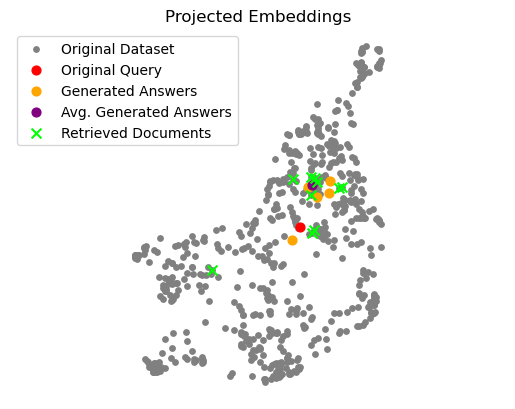

In [27]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=15, c="grey", label="Original Dataset")
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=40, c="red", label="Original Query")
plt.scatter(projected_generated_answers_embedding[:, 0], projected_generated_answers_embedding[:, 1], s=40, c="orange", label="Generated Answers")
plt.scatter(projected_avg_answers_embedding[:, 0], projected_avg_answers_embedding[:, 1], s=40, c="purple", label="Avg. Generated Answers")
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=50, marker="x", c="lime", label="Retrieved Documents")
plt.gca().set_aspect('equal', 'datalim')
plt.title('Projected Embeddings')
plt.legend(loc="best");
plt.axis('off');

## 6. Build RAG

In [28]:
def rag(query, retrieved_documents, model="llama-3.1-70b-versatile"):
    information = "\n\n".join(retrieved_documents)

    messages = [
        {
            "role": "system",
            "content": "You are an expert financial research assistant. Your users are asking questions about information contained in an annual report."
            "You will be given the user's query, and the relevant information from the annual report. Answer the user's question using only this information."
        },
        {"role": "user", "content": f"Question: {query}. \n Information: {information}"}
    ]
    
    response = client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

### 6.1 Simple RAG

In [32]:
output = rag(query=query, retrieved_documents=retrieved_documents1)

print(output)

The risk factors for the company can be summarized as follows:

1. Risks related to product offerings: 
   - Losing users or reducing user engagement
   - Losing or reduction in spending by marketers
   - Reduced availability of data signals for ad targeting and measurement tools
   - Ineffective operation with mobile operating systems or changes in relationships with mobile operating system partners
   - Failure of new products or changes to existing products to attract or retain users or generate revenue

2. Risks related to business operations and financial results:
   - Inability to compete effectively
   - Government regulation and criminal liability
   - Challenges in managing global operations, including economic, legal, and business risks
   - Human capital risks, including loss of key personnel and challenges in attracting and retaining talent
   - Unfavorable media coverage affecting the business

3. Risks related to financials and management:
   - Volatility in user base and

### 6.2 HyDE 

In [33]:
output = rag(query=query, retrieved_documents=retrieved_documents2)

print(output)

The company faces a number of risk factors, including:

Risks Related to Product Offerings:

1. Ability to add and retain users and maintain levels of user engagement with products.
2. Loss of, or reduction in spending by, marketers.
3. Reduced availability of data signals used by ad targeting and measurement tools.
4. Ineffective operation with mobile operating systems or changes in relationships with mobile operating system partners.
5. Failure of new products, or changes to existing products, to attract or retain users or generate revenue.

Risks Related to Business Operations and Financial Results:

1. Ability to compete effectively.
2. Volatility in the size of the user base and user engagement.
3. Delays in product development or releases, or reductions in manufacturing production and sales of consumer hardware.
4. Significant volatility and disruption of global financial markets.
5. Illnesses to key employees, or a significant portion of the workforce, which may result in ineffi

### 6.3 HyDE Averaged Embeddings

In [34]:
output = rag(query=query, retrieved_documents=retrieved_documents3)

print(output)

Based on the information provided, the risk factors for the company include:

1. Risks related to product offerings, such as:
   - Ability to add and retain users and maintain levels of user engagement
   - Loss of or reduction in spending by marketers
   - Reduced availability of data signals used by ad targeting and measurement tools
   - Ineffective operation with mobile operating systems or changes in relationships with mobile operating system partners
   - Failure of new products to attract or retain users or generate revenue

2. Risks related to business operations and financial results, such as:
   - Ability to compete effectively
   - Impact of government regulation and scrutiny
   - Criminal liability or penalties, including substantial monetary remedies
   - Negative publicity and reputational harm
   - Disruption of business practices, diversion of resources, and structural or behavioral remedies

3. Risks related to data, security, platform integrity, and intellectual prope

## Summary

In this video, I explained how to improve RAG app performance using **Hypothetical Document Embeddings (HyDE)** technique. Please feel free to let me know your views.